<a href="https://colab.research.google.com/github/Kevan123/CostRewardOptimizationForBankLoanApprovals/blob/main/Bank_Delinquency_Interest_Rate_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Data Prep** 
a. Import packages/libraries \\
b. Import data \\
c. Clean up dataframe \\

In [ ]:
import pandas as pd
import numpy as np
import random
from numpy.random.mtrand import rand
from random import gauss
from scipy.optimize import curve_fit
from matplotlib import pyplot
from numpy import arange
from math import sqrt

In [ ]:
df = pd.read_excel('df_prepared_scored.xlsx', header=0, sheet_name= 'Sheet1')

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
df.head(5)

,MaskedID,Amt,Int_Rate,Ln_Tenure,Prim_Brnch_ID,Cust_Opn_Dt_parsed,Cust_Tenure,Acct_Opn_Dt_parsed,Ln_Reason_Msk,Birth_Dt_parsed,...,Occup,Acct_Close_Dt_parsed,Cust_Type,Salary,Mrtl_Status,Inc_Rng,Delinq,proba_0,proba_1,prediction
0,46098xxxx2501,50000.0,13.75,3.000000,1.0,2005-04-01T00:00:00.000Z,17.0,2012-07-17T00:00:00.000Z,1-22,1983-02-01T00:00:00.000Z,...,Fire Officer,2015-07-31T00:00:00.000Z,Personal,9188.83,Married,"$5,000 - $9,999.99",1.0,0.063235,0.936765,1.0
1,46046xxxx5501,30000.0,13.75,3.084932,1.0,1996-11-25T00:00:00.000Z,25.0,2012-07-25T00:00:00.000Z,1-22,1960-01-09T00:00:00.000Z,...,Driver,2015-08-31T00:00:00.000Z,Personal,0.0,Married,"$0 - $4,999.99",1.0,0.003075,0.996925,1.0
2,46046xxxx5502,80000.0,12.03,4.002740,1.0,1996-11-25T00:00:00.000Z,25.0,2013-04-15T00:00:00.000Z,1-22,1960-01-09T00:00:00.000Z,...,Driver,2017-04-30T00:00:00.000Z,Personal,0.0,Married,"$0 - $4,999.99",1.0,0.066839,0.933161,1.0
3,46047xxxx1601,78000.0,9.22,2.000000,1.0,1994-12-23T00:00:00.000Z,27.0,2012-11-22T00:00:00.000Z,1-23,1961-03-22T00:00:00.000Z,...,NaN,2014-11-30T00:00:00.000Z,Personal,,,,1.0,0.805389,0.194611,0.0
4,46047xxxx4801,206000.0,8.25,7.087671,1.0,1986-05-05T00:00:00.000Z,36.0,2012-11-30T00:00:00.000Z,1-39,1968-03-25T00:00:00.000Z,...,Police Officer,2019-12-31T00:00:00.000Z,Personal,0.0,Married,"$0 - $4,999.99",1.0,0.179409,0.820591,1.0


In [ ]:
df.drop(df.columns[[0,4,5,6,7,8,9,10,11,12,13,14,15,16,17]], axis = 1, inplace = True)

In [ ]:
df.columns

Index(['Amt', 'Int_Rate', 'Ln_Tenure', 'Delinq', 'proba_0', 'proba_1',
       'prediction'],
      dtype='object')

In [ ]:
df.dtypes

Amt           float64
Int_Rate      float64
Ln_Tenure     float64
Delinq        float64
proba_0       float64
proba_1       float64
prediction    float64
dtype: object

In [ ]:
df.describe()

,Amt,Int_Rate,Ln_Tenure,Delinq,proba_0,proba_1,prediction
count,5.594300e+04,55943.000000,55943.000000,55943.000000,55943.000000,55943.000000,55943.000000
mean,1.214413e+05,9.383913,4.734344,0.100191,0.867086,0.132914,0.100138
std,2.521961e+05,3.002204,1.844681,0.300258,0.287201,0.287201,0.300186
min,0.000000e+00,0.000000,-8.591781,0.000000,0.000053,0.000026,0.000000
25%,5.000000e+04,7.250000,3.169863,0.000000,0.944397,0.003067,0.000000
50%,9.000000e+04,10.260000,4.920548,0.000000,0.990116,0.009884,0.000000
75%,1.600000e+05,11.400000,5.920548,0.000000,0.996933,0.055603,0.000000
max,3.000000e+07,25.000000,34.693151,1.000000,0.999974,0.999947,1.000000


### **2. Add in columns for:**
a. Loan Amt Plus Interest \\
b. Interest \\
c. Return \\

In [ ]:
df["Amt_Plus_Int"] = df["Amt"]+(df["Amt"]*(df["Int_Rate"]/100))*df["Ln_Tenure"]
df["Int"] = df['Amt_Plus_Int'] - df['Amt']

In [ ]:
df['prediction'] = df['prediction'].astype(int)
df['Delinq'] = df['Delinq'].astype(int)

In [ ]:
#df.drop(df.columns[[9]], axis = 1, inplace = True)

In [ ]:
random.seed(0)
def time_delinq(row):
  if row['prediction'] == 1:
    return  gauss(0.5,0.1) ##mean of 0.5 and std dev of 0.1
  return 0

In [ ]:
df['Time_Of_Delinq'] = df.apply(lambda row: time_delinq(row), axis=1)

In [ ]:
df['Return'] = ((1-df['proba_1'])*df['Int']) + (df['proba_1']*(df['Time_Of_Delinq']*df['Int']))-((1-df['Time_Of_Delinq'])*df['Int'])

In [ ]:
df.loc[df.prediction == 0, 'Return'] = df.Int

In [ ]:
df.head(10)

,Amt,Int_Rate,Ln_Tenure,Delinq,proba_0,proba_1,prediction,Amt_Plus_Int,Int,Time_Of_Delinq,Return
0,50000.0,13.75,3.000000,1,0.063235,0.936765,1,70625.000000,20625.000000,0.607937,4963.742836
1,30000.0,13.75,3.084932,1,0.003075,0.996925,1,42725.342466,12725.342466,0.502932,94.061631
2,80000.0,12.03,4.002740,1,0.066839,0.933161,1,118522.367123,38522.367123,0.548746,4917.485514
3,78000.0,9.22,2.000000,1,0.805389,0.194611,0,92383.200000,14383.200000,0.000000,14383.200000
4,206000.0,8.25,7.087671,1,0.179409,0.820591,1,326454.972603,120454.972603,0.776270,71391.147484
5,100000.0,9.39,5.002740,1,0.982539,0.017461,0,146975.726027,46975.726027,0.000000,46975.726027
6,53000.0,11.25,4.002740,1,0.121837,0.878163,1,76866.335616,23866.335616,0.471466,174.863856
7,60000.0,13.02,3.002740,1,0.112181,0.887819,1,83457.402740,23457.402740,0.544535,3287.871232
8,60000.0,7.50,3.002740,1,0.015421,0.984579,1,73512.328767,13512.328767,0.555173,1583.716639
9,36000.0,13.00,0.915068,1,0.001262,0.998738,1,40282.520548,4282.520548,0.545044,388.266034


In [ ]:
#need to optimize values of I such P can decrease and R can increase but realistically - this may also influence the Amt & Ln_Tenure

### **Taking a specific cohort of customers to optimize their interest rate to give a greater return**

In [ ]:
#df_sub = df.loc[(df['Int_Rate'] == 7.5) & (df['prediction'] <= 1)]
df_sub = df.loc[(df['prediction']==1) & (df['proba_1']>0.980)]

In [ ]:
df_sub.tail(10)

,Amt,Int_Rate,Ln_Tenure,Delinq,proba_0,proba_1,prediction,Amt_Plus_Int,Int,Time_Of_Delinq,Return
9603,500000.00,6.75,3.002740,0,0.008146,0.991854,1,6.013425e+05,101342.465753,0.518710,4189.594590
12407,109900.00,14.50,2.101370,0,0.000760,0.999240,1,1.433864e+05,33486.379452,0.626774,8499.898137
17152,25000.00,12.75,1.915068,0,0.014472,0.985528,1,3.110428e+04,6104.280822,0.390797,-1279.391937
21891,70000.00,14.50,0.498630,0,0.012289,0.987711,1,7.506110e+04,5061.095890,0.699627,2039.348584
41139,196000.00,9.56,5.002740,0,0.014671,0.985329,1,2.897393e+05,93739.335890,0.639403,26631.002196
42259,1000000.00,9.50,4.917808,0,0.012362,0.987638,1,1.467192e+06,467191.780822,0.477917,-17618.993156
55910,1000000.00,7.50,2.923288,0,0.015762,0.984238,1,1.219247e+06,219246.575342,0.576885,35175.650608
55913,500000.00,0.00,1.054795,0,0.009304,0.990696,1,5.000000e+05,0.000000,0.435338,0.000000
55924,108000.00,14.00,4.920548,0,0.017687,0.982313,1,1.823987e+05,74398.684932,0.327518,-24779.991484
55938,2368219.53,14.50,0.838356,0,0.017113,0.982887,1,2.656104e+06,287884.659030,0.475635,-11445.547125


In [ ]:
df_sub.describe()

,Amt,Int_Rate,Ln_Tenure,Delinq,proba_0,proba_1,prediction,Amt_Plus_Int,Int,Time_Of_Delinq
count,3.197000e+03,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.0,3.197000e+03,3.197000e+03,3197.000000
mean,1.685614e+05,13.794697,2.782959,0.996872,0.005013,0.994987,1.0,2.357531e+05,6.719167e+04,0.499302
std,5.873567e+05,3.932314,1.594299,0.055849,0.005142,0.005142,0.0,7.708091e+05,2.691035e+05,0.100975
min,0.000000e+00,0.000000,-8.591781,0.000000,0.000053,0.980046,1.0,-1.169315e+04,-1.116932e+05,0.168183
25%,2.950000e+04,11.750000,1.917808,1.000000,0.001053,0.992339,1.0,3.673969e+04,7.656164e+03,0.430066
50%,5.684216e+04,13.750000,2.920548,1.000000,0.002927,0.997073,1.0,7.872791e+04,1.977740e+04,0.500672
75%,1.300000e+05,16.000000,3.758904,1.000000,0.007661,0.998947,1.0,1.864663e+05,5.063466e+04,0.569861
max,2.000000e+07,25.000000,20.013699,1.000000,0.019954,0.999947,1.0,2.130356e+07,6.074893e+06,0.853540


### **3. Create quadratic function for a specific cohort**

In [ ]:
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

y = 592.45917 * x + -20.15461 * x^2 + -3404.28337


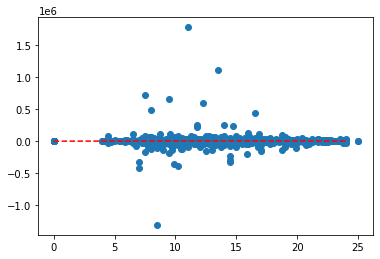

In [ ]:
# choose the input and output variables
x = df_sub.iloc[:,1]
y = df_sub.iloc[:,-1]
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

### **4. Optimize interest rate to yield higher return**

In [ ]:

check_input = True
while check_input:
    a, b, c = eval(input("Please enter the a, b, c coefficients of your quadratic equation: "))
    try: 
        float(a), float(b), float(c)
        check_input = False
    except ValueError:
        print("Please make sure the coefficients are real numbers and try again")
        check_input = True

disc = b*b-4*a*c

if disc >= 0:
    x1 = (-b+sqrt(disc))/(2*a)
    x2 = (-b-sqrt(disc))/(2*a)
    print("The roots of the equation are:", x1, x2)
else:
    print("The equation has no solutions")

Please enter the a, b, c coefficients of your quadratic equation: 592.45917, -20.15461, -3404.28337
The roots of the equation are: 2.414155756913529 -2.380137193237655


In [ ]:
max_y = max(y_line)  # Find the maximum y value
max_x = x_line[y_line.argmax()]  # Find the x value corresponding to the maximum y value
print (max_x, max_y)

15.0 947.8178810981931
